![Notebooks in Portuguese](https://img.shields.io/badge/Notebooks-Portuguese-yellow?style=flat-square)
![Translate with jupyter-translate](https://img.shields.io/badge/Translate-Jupyter--Translate-blue?style=flat-square)
> ⚠️ **Note:** The notebooks in this repository are written in Portuguese, but the code, functions, and variables are all in English.  
> If you prefer another language, use tools like [jupyter-translate](https://github.com/WittmannF/jupyter-translate) to automatically translate cells inside JupyterLab.  
> See [USAGE.md](./USAGE.md) for function documentation in both Portuguese and English.


# Análise Climática com TerraClimate usando geemap-tools

Este pequeno notebook serve para demonstrar como extrair informações sobre variáveis climáticas dentro de um ROI, usando o `geemap-tools`. Aqui, extraimos média, mediana e desvio padrão de todos os pixels dentro de um dado ROI, usando o TerraCLimate (https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE?hl=pt-br). 

## Sobre o TerraClimate

O **TerraClimate** é um conjunto de dados mensais de clima e balanço hídrico superficial com cobertura global para superfícies terrestres. Ele combina:

- A climatologia de alta resolução espacial do **WorldClim**
- Com as anomalias temporais de menor resolução espacial, porém mais extensas, do **CRU Ts4.0** e da **Reanálise JRA55**

### Como funciona
O procedimento aplica anomalias mensais do CRU Ts4.0/JRA55 sobre a climatologia espacial do WorldClim, criando assim uma série histórica detalhada em termos espaciais e temporais.

### Origem dos dados
- As **variáveis principais** (temperatura, precipitação, pressão de vapor) vêm principalmente do **CRU Ts4.0**
- Regiões sem dados do CRU (como Antártica, partes da África e América do Sul) usam dados da **reanálise JRA55**
- A **radiação solar** e o **vento** são derivados exclusivamente da **JRA55**
- O número de estações meteorológicas que contribuíram para o CRU (0 a 8) também é disponibilizado

### Balanço hídrico
O TerraClimate fornece estimativas mensais de:
- **Evapotranspiração de referência (ET0)**
- **Balanço hídrico climático**, com base em um modelo simplificado de **Thornthwaite-Mather**
- **Capacidade de água extraível** do solo, com base em dados globais interpolados (Wang-Erlandsson et al., 2016)

### Limitações dos dados
- **Tendências de longo prazo** são herdadas dos dados CRU/JRA55, e **não devem ser usadas para análises independentes de tendência**
- Não captura **variabilidade em escalas temporais pequenas**
- Não representa bem a **precipitação orográfica** ou inversões complexas
- O modelo hídrico é **simplificado**: não considera heterogeneidade de vegetação ou resposta fisiológica
- **Validação limitada** em regiões remotas e com baixa densidade de observações, como a Antártica


In [1]:
import warnings ## <- apenas para deixar a saída mais limpa. Se quiser pode comentar.
warnings.filterwarnings("ignore", category=UserWarning)

import ee
import geemap
import geemap_tools as gee
ee.Authenticate()
ee.Initialize(project='ee-andrebelem') # << note que vc tem que mudar para o seu projeto

## Definição da área de estudo (ROI)
Aqui definimos a área de interesse. No nosso caso vamos usar a Floresta da Tijuca, já carregada como variável `tijuca`.

In [2]:
# Carrega ROI já preparada
tijuca = gee.file_to_roi("Floresta_da_Tijuca_original.zip").geometry()

## Extração das variáveis climáticas da coleção TerraClimate
Neste passo, usamos a função `get_TerraClimate` para obter dados climáticos mensais da coleção TerraClimate entre 2000 e 2025 para as variáveis de interesse (no nosso caso, precipitação, evapotranspiração, temperatura máxima e mínima). Note que escolhemos os dados entre 2020 e 2024 mas o conjunto de dados TerraClimate cobre o período de janeiro de 1958 até o mês mais recente disponível, com atualizações mensais.

In [3]:
# Extração de dados TerraClimate (somente médias)
df_clima = gee.analysis.get_TerraClimate(
    roi=tijuca,
    start="2020-01-01",
    end="2024-12-31",
    variables=["pr", "pet", "tmmx", "tmmn", "srad"],
    stats=["mean"],
    debug=True
)

[DEBUG] Imagens na coleção: 60
[DEBUG] Variáveis selecionadas: ['pr', 'pet', 'tmmx', 'tmmn', 'srad']
[DEBUG] Estatísticas selecionadas: ['mean']
[DEBUG] Linhas retornadas: 60
[DEBUG] Colunas: ['pet_mean', 'pr_mean', 'srad_mean', 'tmmn_mean', 'tmmx_mean']


In [4]:
# vamos ver como os dados são apresentados
df_clima.head()

,pet_mean,pr_mean,srad_mean,tmmn_mean,tmmx_mean
date,,,,,
2020-01-01,117.146800,17.701174,195.088021,20.069583,29.102936
2020-02-01,84.163417,34.261597,146.539930,19.538520,28.555549
2020-03-01,97.594069,20.328479,180.336935,18.664005,27.073635
2020-04-01,75.496477,6.960716,147.299413,17.419847,25.667293
2020-05-01,69.883089,8.510276,141.965708,15.491133,23.900646


In [6]:
# vamos extrair agora com _mean, _median e _stdDev para ver as diferenças
df_clima = gee.analysis.get_TerraClimate(
    roi=tijuca,
    start="2020-01-01",
    end="2024-12-31",
    variables=["pr", "pet"],
    stats=["mean", "median", "stdDev"],
    debug=True
)

[DEBUG] Imagens na coleção: 60
[DEBUG] Variáveis selecionadas: ['pr', 'pet']
[DEBUG] Estatísticas selecionadas: ['mean', 'median', 'stdDev']
[DEBUG] Linhas retornadas: 60
[DEBUG] Colunas: ['pet_mean', 'pet_median', 'pet_stdDev', 'pr_mean', 'pr_median', 'pr_stdDev']


## Visualização gráfica das variáveis climáticas
Uma excelente estratégia gráfica é plotar os dados de precipitação média e a evapotranspiração potencial com média, mediana e faixa de ±1 desvio padrão em cinza. Isso dá uma boa ideia da cobertura de dados na área.

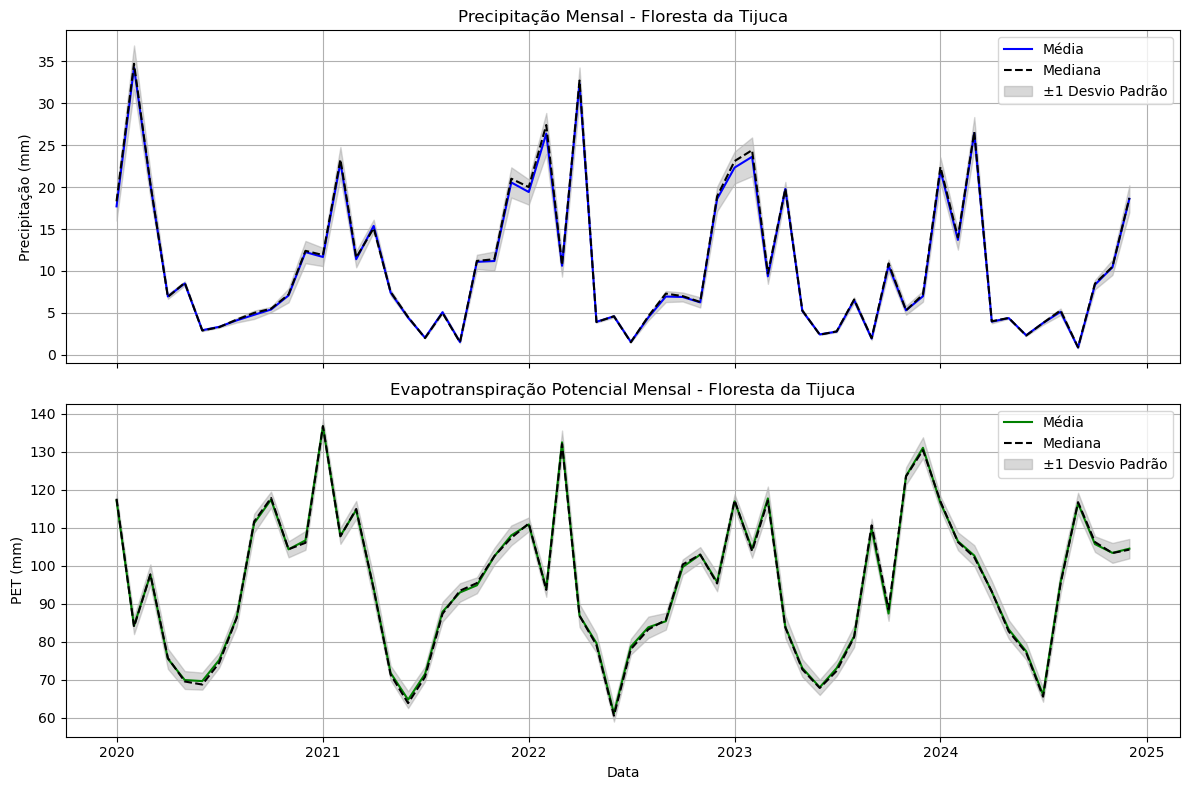

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Garante tipo numérico adequado
df_clima = df_clima.astype("float64")

# Cria figura com 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# === Precipitação ===
axs[0].plot(df_clima.index, df_clima["pr_mean"], label="Média", color="blue")
axs[0].plot(df_clima.index, df_clima["pr_median"], label="Mediana", color="black", linestyle="--")
axs[0].fill_between(df_clima.index,
                    df_clima["pr_mean"] - df_clima["pr_stdDev"],
                    df_clima["pr_mean"] + df_clima["pr_stdDev"],
                    color="gray", alpha=0.3, label="±1 Desvio Padrão")

axs[0].set_title("Precipitação Mensal - Floresta da Tijuca")
axs[0].set_ylabel("Precipitação (mm)")
axs[0].legend()
axs[0].grid(True)

# === PET ===
axs[1].plot(df_clima.index, df_clima["pet_mean"], label="Média", color="green")
axs[1].plot(df_clima.index, df_clima["pet_median"], label="Mediana", color="black", linestyle="--")
axs[1].fill_between(df_clima.index,
                    df_clima["pet_mean"] - df_clima["pet_stdDev"],
                    df_clima["pet_mean"] + df_clima["pet_stdDev"],
                    color="gray", alpha=0.3, label="±1 Desvio Padrão")

axs[1].set_title("Evapotranspiração Potencial Mensal - Floresta da Tijuca")
axs[1].set_ylabel("PET (mm)")
axs[1].set_xlabel("Data")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
